# Set-up

In [21]:
import networkx as nx
from node2vec import Node2Vec
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [15]:
def randomly_remove_links(G, n_missing):

    my_edges = np.array(list(G.edges))
    number_of_rows = my_edges.shape[0]
    rnd_idx = np.random.choice(number_of_rows,
                               size = n_missing,
                               replace = False)

    pair = my_edges[rnd_idx, :]

    for p in pair:
        G.remove_edge(p[0], p[1])

def get_representation_index_hash(G, params):

    dimensions, walk_length, num_walks, workers,\
    window, min_count, batch_words = params

    n2v = Node2Vec(G,
                   dimensions = dimensions,
                   walk_length = walk_length,
                   num_walks = num_walks,
                   workers = workers,
                   )

    embedding = n2v.fit(window = window,
                        min_count = min_count,
                        batch_words = batch_words,
                        )

    index_ = embedding.wv.index_to_key
    vectors_ = embedding.wv.vectors

    vectors = {int(index_[idx]): vectors_[idx] for idx in range(G.number_of_nodes())}

    representation = [] # maybe this should be an array, not a list?? if done, check here: [ ]
    n_node = G.number_of_nodes()

    for i in range(n_node):
        representation.append(embedding.wv['%d'%i])

    return representation

def calc_cosine_similarity(vec1, vec2):

    n = len(vec1)
    cos_sim = 0.

    for i in range(n):
        cos_sim += np.dot(vec1[i], vec2[i]) /\
        (np.linalg.norm(vec1[i]) * np.linalg.norm(vec2[i]))

    cos_sim /= n

    return cos_sim

def calc_euclidean_distance(vec1, vec2):

    n = len(vec1)
    euc_dist = 0.

    for i in range(n):
        euc_dist += np.linalg.norm(vec1[i] - vec2[i])

    euc_dist /= n

    return euc_dist


In [16]:
n_node = 1000 # size of ring lattice
n_missing = 10 # number of missing edges

dimensions = 128 # euclidean dimension to embedd
walk_length = 30 # number of nodes in each walk
num_walks = 100 # number of walks per node
workers = 10 # for cpu parallel work

window = 10 # Maximum distance between the current and predicted word within a sentence.
min_count = 1 #ignores all words with total frequency lower than this
batch_words = 4

repeat = 5

# Messing About

In [17]:
ring_lattice = nx.cycle_graph(n_node)
ring_missing = nx.cycle_graph(n_node)
randomly_remove_links(ring_missing, n_missing)

print(f"Number of edges - Control: {ring_lattice.number_of_edges()} Experiment: {ring_missing.number_of_edges()}")

Number of edges - Control: 1000 Experiment: 990


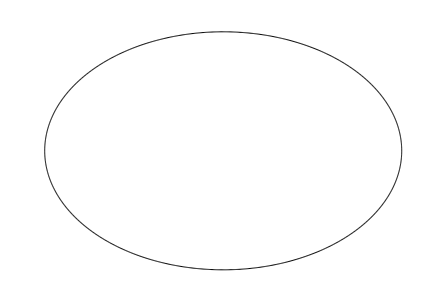

In [18]:
nx.draw(ring_lattice, pos=nx.circular_layout(ring_lattice), node_size=0)

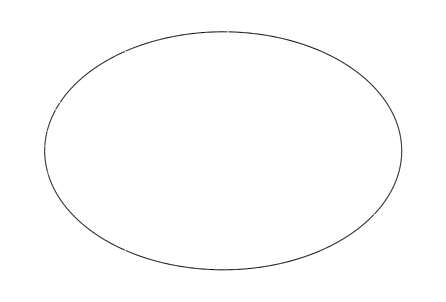

In [19]:
nx.draw(ring_missing, pos=nx.circular_layout(ring_lattice), node_size=0)

In [20]:
'''
Get vector representation
'''

param = [dimensions, walk_length, num_walks, workers,
        window, min_count, batch_words]

list_dist_control = []
list_cosim_control = []
list_dist_exp = []
list_cosim_exp = []
for i in range(repeat):
    print(f'{i}-th iteration')
    rep_ring = get_representation_index_hash(ring_lattice, param)
    rep_ring_cont = get_representation_index_hash(ring_lattice, param)
    rep_ring_exp = get_representation_index_hash(ring_missing, param)

    '''
    Calcualte euclidean distance
    '''

    dist_control = calc_euclidean_distance(rep_ring, rep_ring_cont)
    cosim_control = calc_cosine_similarity(rep_ring, rep_ring_cont)

    dist_exp = calc_euclidean_distance(rep_ring, rep_ring_exp)
    cosim_exp = calc_cosine_similarity(rep_ring, rep_ring_exp)

    #############################################
    # NEED TO SAVE INDIVIDUAL DISTANCES btw same nodes HERE
    #############################################

    list_dist_control.append(dist_control)
    list_cosim_control.append(cosim_control)
    list_dist_exp.append(dist_exp)
    list_cosim_exp.append(cosim_exp)

    #############################################
    # NEED TO SAVE avg DISTANCES
    #############################################


0-th iteration


Generating walks (CPU: 9): 100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


1-th iteration


Generating walks (CPU: 9): 100%|██████████| 10/10 [00:12<00:00,  1.24s/it]


2-th iteration


Generating walks (CPU: 8): 100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


3-th iteration


Generating walks (CPU: 10): 100%|██████████| 10/10 [00:12<00:00,  1.24s/it]


4-th iteration


Generating walks (CPU: 10): 100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


In [22]:
rep_ring = np.array(rep_ring)
rep_ring_cont = np.array(rep_ring_cont)
rep_ring_exp = np.array(rep_ring_exp)
np.savez("../_tmp/dk_mk_ring_exp.npz", ring=rep_ring, cont=rep_ring_cont, exp=rep_ring_exp)

In [23]:
ring_proj = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(rep_ring)
control_proj = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(rep_ring_cont)
exp_proj = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(rep_ring_exp)

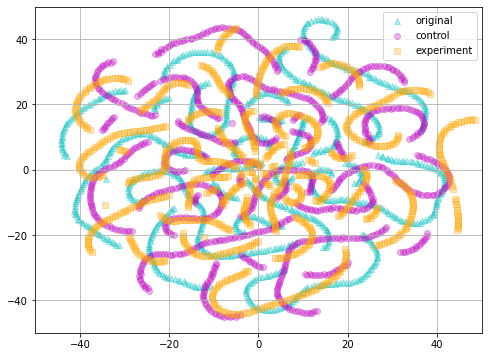

In [25]:
n_point = -1

fig, ax = plt.subplots(figsize = (8, 6))

ax.scatter(ring_proj[:, 0][:n_point], ring_proj[:, 1][:n_point], 
           c = 'c',
           marker = '^',
           alpha = 0.3,
           label = 'original',)
ax.scatter(control_proj[:, 0][:n_point], control_proj[:, 1][:n_point], 
           c = 'm', 
           marker = 'o', 
           alpha = 0.3,
           label = 'control',)
ax.scatter(exp_proj[:, 0][:n_point], exp_proj[:, 1][:n_point],
           c = 'orange', 
           marker = 's',
           alpha = 0.3,
           label = 'experiment',)
ax.set_xlim(-50, 50)
ax.set_ylim(-50, 50)
ax.legend()
plt.grid()
plt.show()